In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from imageio import imread
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from scipy.ndimage import median_filter
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

sns.set_theme(style="darkgrid")

In [115]:
# Path to dataset
IMG_DIR = 'shipsnet'
class1 = []
class0 = []
for file in os.listdir(IMG_DIR):
    loaded_img = imread(os.path.join(IMG_DIR, file))
    if file[0] == '0':
        class0.append(loaded_img)
    else:
        class1.append(loaded_img)
class1 = np.array(class1)
class0 = np.array(class0)

print("Original Class0 and Class1 Shapes:")
print(f"Class 1 shape: {class1.shape}")
print(f"Class 0 shape: {class0.shape}")

# # downsampling class 0
# downsample_idx = np.random.choice(range(len(class0)), len(class1))
# class0 = class0[downsample_idx]

# print("Class0 and Class1 Shapes After Downsampling:")
# print(f"Class 1 shape: {class1.shape}")
# print(f"Class 0 shape: {class0.shape}")

/var/folders/z2/k1ddzt7d0q32_935myb4fz300000gn/T/ipykernel_76397/2794036590.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  loaded_img = imread(os.path.join(IMG_DIR, file))


Original Class0 and Class1 Shapes:
Class 1 shape: (1000, 80, 80, 3)
Class 0 shape: (3000, 80, 80, 3)


### Applying Median Filter & Visualizing Effects

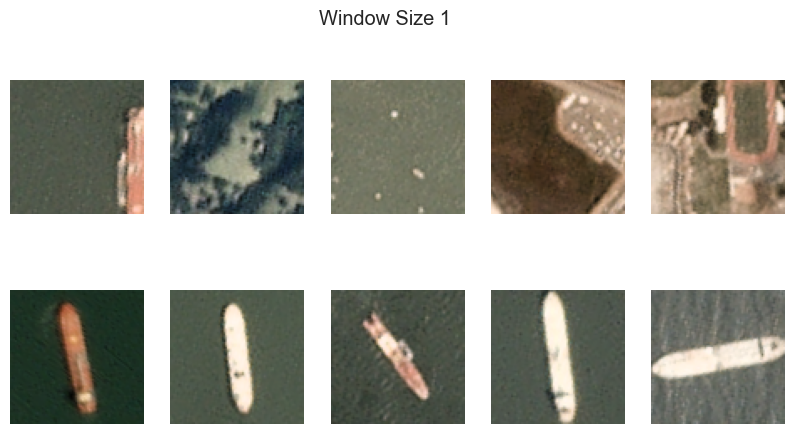

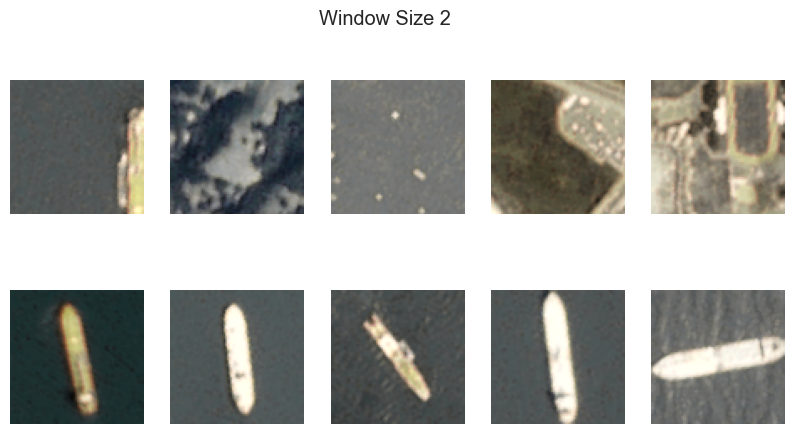

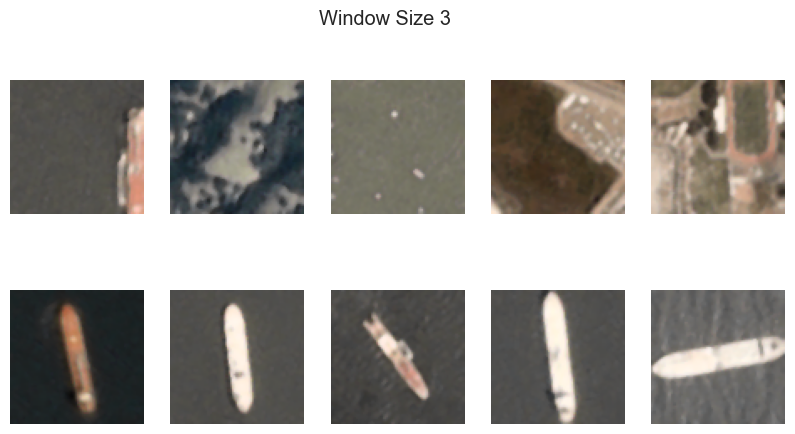

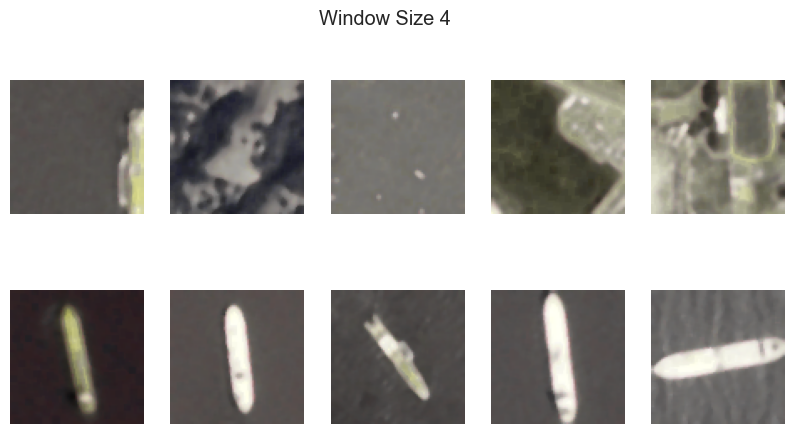

In [116]:
# Function to apply median filtering to images
def apply_median_filter(image, window_size=3): # Window size is set to 3.
    filtered_image = median_filter(image, size=window_size)
    return filtered_image

np.random.seed = 888
class0_sample = class0[np.random.choice(range(len(class0)), 5)]
class1_sample = class1[np.random.choice(range(len(class1)), 5)]

for window_size in [1, 2, 3, 4]:
    class0_sample_filtered = np.array([apply_median_filter(img, window_size) for img in class0_sample])
    class1_sample_filtered = np.array([apply_median_filter(img, window_size) for img in class1_sample])
    
    fig, axs = plt.subplots(2, 5, figsize=(10, 5))

    for idx, img in enumerate(class0_sample_filtered):
        axs[0][idx].imshow(img)
        axs[0][idx].axis('off')

    for idx, img in enumerate(class1_sample_filtered):
        axs[1][idx].imshow(img)
        axs[1][idx].axis('off')
    plt.suptitle(f"Window Size {window_size}")
    plt.show()

Window Size 3 appears to reduce noise the best. Window size 4 appears to begin to actually remove salient features, so it's probably too extreme.

**EDIT**: Window Size 3 may be removing salient features on the boats themselves, as our model is making false positive predictions on images that are boat-shaped but do not have other boat features. So, dropping window size 2 to ensure that those features don't get averaged out.

In [117]:
# Applying median filtering to images
class1_filtered = np.array([apply_median_filter(img, 2) for img in class1])
class0_filtered = np.array([apply_median_filter(img, 2) for img in class0])

### Splitting Data

In [118]:
# Concatenating filtered images
X = np.concatenate((class1_filtered, class0_filtered), axis=0)
y = np.concatenate((np.ones(class1.shape[0]), np.zeros(class0.shape[0])), axis=0)

# Split the dataset into training, validation, and testing sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# Normalizing pixel values to the range [0, 1]
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

### Baseline Model

In [119]:
# Flattening the image data
X_train_flat = X_train.reshape(X_train.shape[0], -1)
# X_test_flat = X_test.reshape(X_test.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)

# Initializing and training the Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_flat, y_train)

# Making predictions on the test set
y_pred_rf = rf_model.predict(X_val_flat)

# Calculating test accuracy
accuracy_rf = accuracy_score(y_val, y_pred_rf)
print("Random Forest Accuracy:", accuracy_rf)

Random Forest Accuracy: 0.955


### Data Augmentation

In [120]:
# Data augmentation to improve generalization

# define preprocessing function to randomly adjust saturation and contrast
# these are not available by default in ImageDataGenerator
def apply_random_effects(img):
    img = tf.image.random_contrast(
        image = img, lower = 0.8, upper = 1.2, 
        seed = 888
    )
    img = tf.image.random_saturation(
        image = img, lower = 0.8, upper = 1.2,
        seed = 888)
    img = tf.image.random_brightness(
        image = img, max_delta = 0.2, seed = 888
    )
    return img

datagen = ImageDataGenerator(
    rotation_range=20,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.2,
    # zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function = apply_random_effects
)

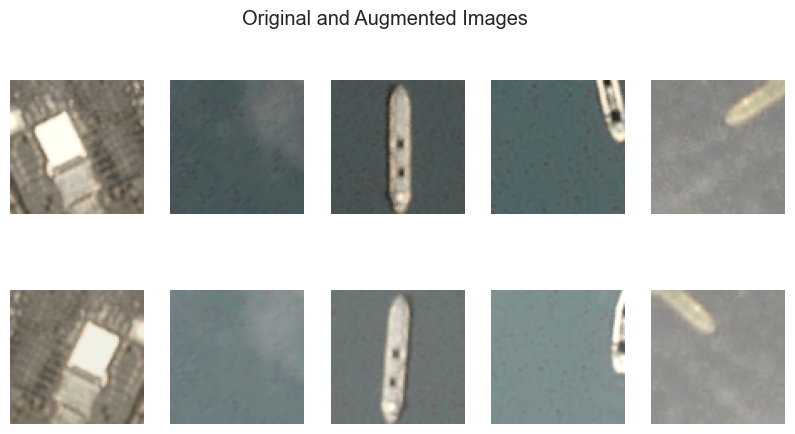

In [121]:
# visualizing the effects of datagen.flow
aug_imgs = datagen.flow(X_train[10:15], shuffle=False)[0]
fig, axs = plt.subplots(2, 5, figsize=(10, 5))

for idx, img in enumerate(X_train[10:15]):
    axs[0][idx].imshow(img)
    axs[0][idx].axis('off')

for idx, img in enumerate(aug_imgs):
    axs[1][idx].imshow(img)
    axs[1][idx].axis('off')
plt.suptitle(f"Original and Augmented Images")
plt.show()

### Modeling

In [122]:
def build_fit_cnn_model(
    augment_imgs = False,
    early_stopping = False,
    epochs = 10,
    learning_rate = 0.001
) -> tuple[tf.keras.Model, tf.keras.callbacks.History]:
    
    input = tf.keras.layers.Input(
        shape=(80,80,3), 
        dtype=tf.float32, 
        name='input')

    conv_1 = tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=(5, 5),
        strides=(1, 1),
        padding='same',
        data_format='channels_last',
        name='conv_1',
        activation='relu')(input)

    max_pool_1 = tf.keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        name='max_pool_1'
    )(conv_1)

    conv_2 = tf.keras.layers.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        strides=(1, 1),
        padding='same',
        name='conv_2',
        activation='relu'
    )(max_pool_1)

    max_pool_2 = tf.keras.layers.MaxPooling2D(
        pool_size = (2, 2),
        name = 'max_pool_2'
    )(conv_2)

    flatten = tf.keras.layers.Flatten()(max_pool_2)

    dense_1 = tf.keras.layers.Dense(
        units=512,
        name='dense_1',
        activation='relu'
    )(flatten)

    dropout = tf.keras.layers.Dropout(
        rate = 0.5
    )(dense_1)

    output = tf.keras.layers.Dense(
        units = 1,
        name = 'output',
        activation = 'sigmoid'
    )(dropout)

    model = tf.keras.Model(
        inputs=input, 
        outputs=output, 
        name='Satellite-Ship-Classifier'
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
        loss='binary_crossentropy', 
        metrics=['accuracy'],
    )
    
    callbacks = []
    if early_stopping:
        es = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3
        )
        callbacks.append(es)
    
    if augment_imgs:
        history = model.fit(
            datagen.flow(X_train, y_train, batch_size=32),
            batch_size = 32,
            steps_per_epoch = len(X_train) // 32,
            epochs = epochs,
            validation_data = (X_val, y_val),
            callbacks = callbacks
        )
        
    else:
        history = model.fit(
            X_train, y_train,
            batch_size = 32,
            steps_per_epoch = len(X_train) // 32,
            epochs = epochs,
            validation_data = (X_val, y_val),
            callbacks = callbacks
        )



    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print("Test Accuracy:", test_accuracy)
    
    return model, history

model_no_aug, history_no_aug = build_fit_cnn_model(
    augment_imgs = False,
    early_stopping = True,
    epochs = 15,
    learning_rate = 0.001
)
model_aug, history_aug = build_fit_cnn_model(
    augment_imgs = True,
    early_stopping = True,
    epochs = 15,
    learning_rate = 0.001
)

Epoch 1/15
75/75 [==============================] - 8s 96ms/step - loss: 0.3159 - accuracy: 0.8742 - val_loss: 0.1825 - val_accuracy: 0.9237
Epoch 2/15
75/75 [==============================] - 7s 100ms/step - loss: 0.1737 - accuracy: 0.9321 - val_loss: 0.1943 - val_accuracy: 0.9137
Epoch 3/15
75/75 [==============================] - 6s 86ms/step - loss: 0.1589 - accuracy: 0.9392 - val_loss: 0.1495 - val_accuracy: 0.9287
Epoch 4/15
75/75 [==============================] - 6s 86ms/step - loss: 0.1123 - accuracy: 0.9542 - val_loss: 0.1554 - val_accuracy: 0.9287
Epoch 5/15
75/75 [==============================] - 7s 89ms/step - loss: 0.0932 - accuracy: 0.9683 - val_loss: 0.1317 - val_accuracy: 0.9463
Epoch 6/15
75/75 [==============================] - 7s 91ms/step - loss: 0.0853 - accuracy: 0.9671 - val_loss: 0.1111 - val_accuracy: 0.9538
Epoch 7/15
75/75 [==============================] - 8s 103ms/step - loss: 0.0936 - accuracy: 0.9642 - val_loss: 0.0894 - val_accuracy: 0.9650
Epoch 8/15


Epoch 1/15


2024-03-24 12:10:55.697016: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


75/75 [==============================] - 8s 109ms/step - loss: 0.4457 - accuracy: 0.8271 - val_loss: 0.2602 - val_accuracy: 0.8900
Epoch 2/15
75/75 [==============================] - 8s 105ms/step - loss: 0.2072 - accuracy: 0.9129 - val_loss: 0.1810 - val_accuracy: 0.9287
Epoch 3/15
75/75 [==============================] - 10s 132ms/step - loss: 0.1832 - accuracy: 0.9279 - val_loss: 0.1878 - val_accuracy: 0.9287
Epoch 4/15
75/75 [==============================] - 9s 115ms/step - loss: 0.1747 - accuracy: 0.9333 - val_loss: 0.1352 - val_accuracy: 0.9488
Epoch 5/15
75/75 [==============================] - 7s 95ms/step - loss: 0.1343 - accuracy: 0.9475 - val_loss: 0.1054 - val_accuracy: 0.9600
Epoch 6/15
75/75 [==============================] - 7s 97ms/step - loss: 0.1204 - accuracy: 0.9533 - val_loss: 0.0893 - val_accuracy: 0.9700
Epoch 7/15
75/75 [==============================] - 8s 101ms/step - loss: 0.0989 - accuracy: 0.9642 - val_loss: 0.1067 - val_accuracy: 0.9638
Epoch 8/15
75/75 [

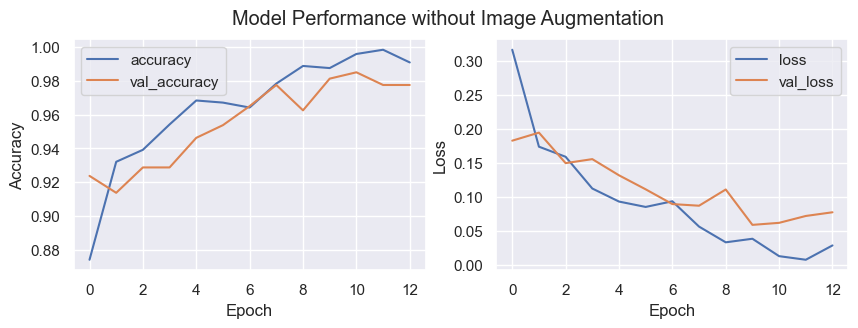

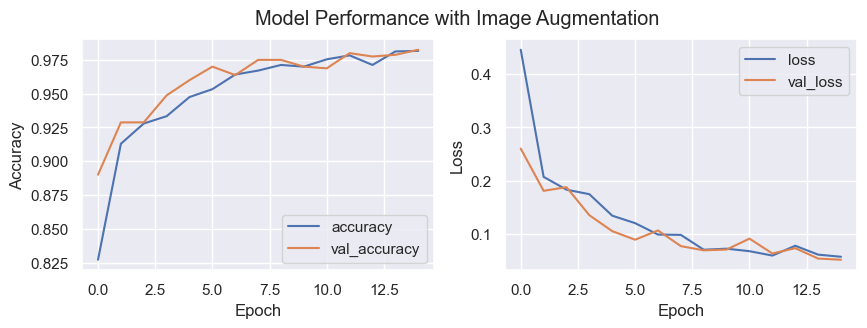

In [123]:
# Plot training history
def plot_acc_loss(history, title=None):
    fig, axs = plt.subplots(1, 2, figsize=(10, 3))
    axs[0].plot(history.history['accuracy'], label='accuracy')
    axs[0].plot(history.history['val_accuracy'], label='val_accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend()

    axs[1].plot(history.history['loss'], label='loss')
    axs[1].plot(history.history['val_loss'], label='val_loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].legend()
    
    plt.suptitle(title)

    plt.show()
    
plot_acc_loss(history_no_aug, 'Model Performance without Image Augmentation')
plot_acc_loss(history_aug, "Model Performance with Image Augmentation")

In [124]:
history_aug_df = pd.DataFrame(history_aug.history)
history_aug_df.columns = [f"{col}_aug" for col in history_aug_df.columns]
history_no_aug_df = pd.DataFrame(history_no_aug.history)
history_no_aug_df.columns = [f"{col}_no_aug" for col in history_no_aug_df.columns]
both = pd.concat([history_aug_df, history_no_aug_df], axis=1)
both = both[sorted(both.columns)]
both

,accuracy_aug,accuracy_no_aug,loss_aug,loss_no_aug,val_accuracy_aug,val_accuracy_no_aug,val_loss_aug,val_loss_no_aug
0,0.827083,0.874167,0.445653,0.315889,0.89000,0.92375,0.260174,0.182485
1,0.912917,0.932083,0.207172,0.173678,0.92875,0.91375,0.181010,0.194290
2,0.927917,0.939167,0.183159,0.158856,0.92875,0.92875,0.187839,0.149535
3,0.933333,0.954167,0.174677,0.112293,0.94875,0.92875,0.135211,0.155416
4,0.947500,0.968333,0.134346,0.093154,0.96000,0.94625,0.105355,0.131676
5,0.953333,0.967083,0.120360,0.085260,0.97000,0.95375,0.089262,0.111093
6,0.964167,0.964167,0.098930,0.093560,0.96375,0.96500,0.106706,0.089448
7,0.967083,0.978333,0.098308,0.056417,0.97500,0.97750,0.077235,0.087054
8,0.971250,0.988750,0.070481,0.033345,0.97500,0.96250,0.069356,0.110873
9,0.970000,0.987500,0.072440,0.038587,0.97000,0.98125,0.070818,0.058953


25/25 [==============================] - 1s 25ms/step


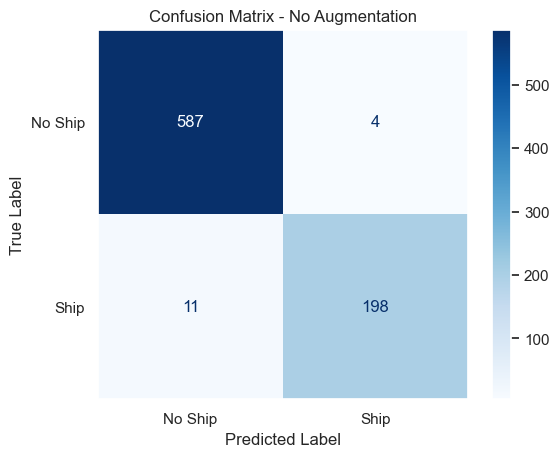

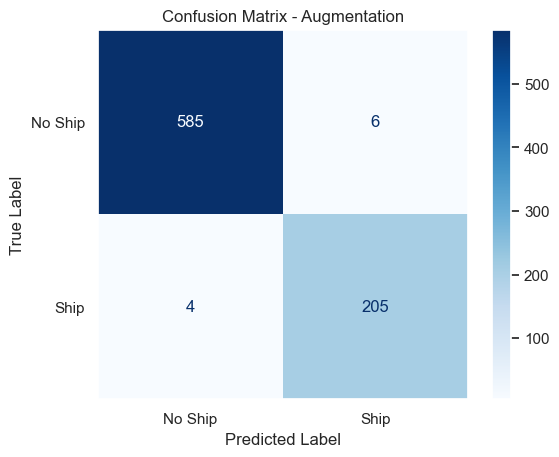

In [125]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def make_predictions(model, data):
    # Making predictions
    predictions = model.predict(data)
    # Converting predictions to binary labels (0 or 1)
    predictions = (predictions > 0.5).astype(int)
    return predictions

def plot_confusion_matrix(pred_labels, true_labels, title):
    
    # Generate confusion matrix
    cm = confusion_matrix(true_labels, pred_labels)

    # Display confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Ship', 'Ship'])
    disp.plot(cmap='Blues')
    plt.grid(False)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    
pred_labels_no_aug = make_predictions(model_no_aug,X_test)
pred_labels_aug = make_predictions(model_aug, X_test)

plot_confusion_matrix(pred_labels_no_aug, y_test, 'Confusion Matrix - No Augmentation')
plot_confusion_matrix(pred_labels_aug, y_test, 'Confusion Matrix - Augmentation')

In [126]:
errors_no_aug_class0 = X_test[(pred_labels_no_aug[:,0] != y_test) & (y_test == 0)]
errors_no_aug_class1 = X_test[(pred_labels_no_aug[:,0] != y_test) & (y_test == 1)]

errors_aug_class0 = X_test[(pred_labels_aug[:,0] != y_test) & (y_test == 0)]
errors_aug_class1 = X_test[(pred_labels_aug[:,0] != y_test) & (y_test == 1)]

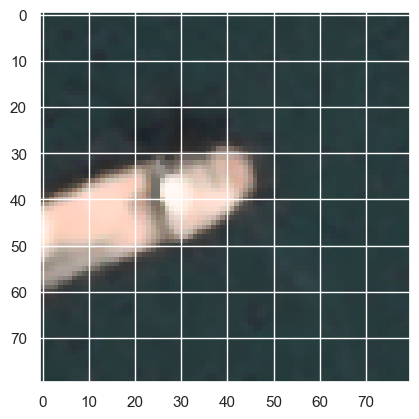

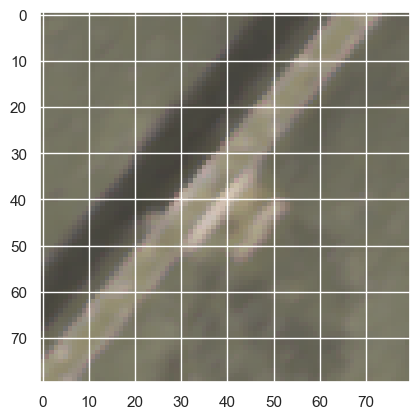

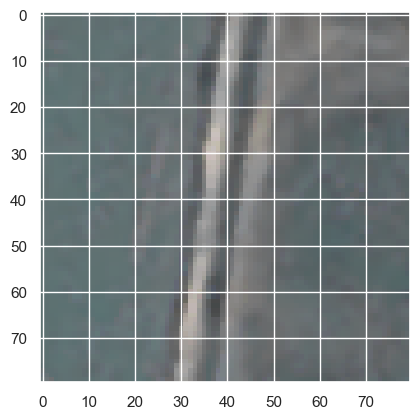

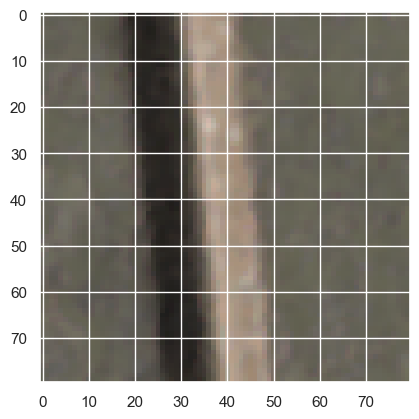

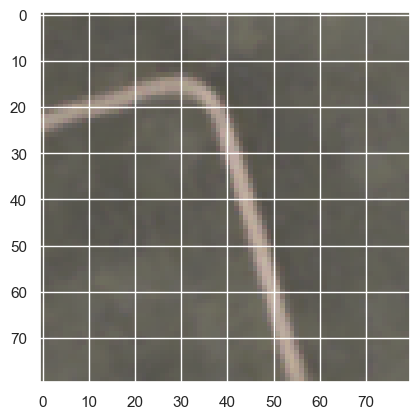

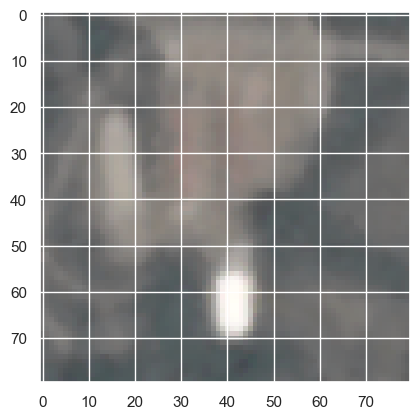

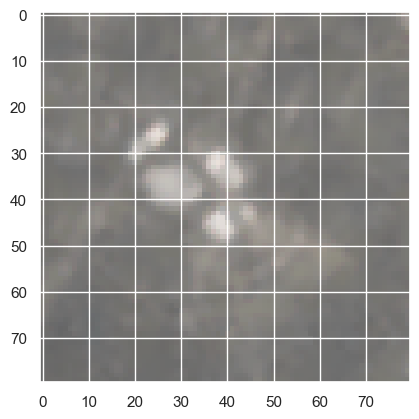

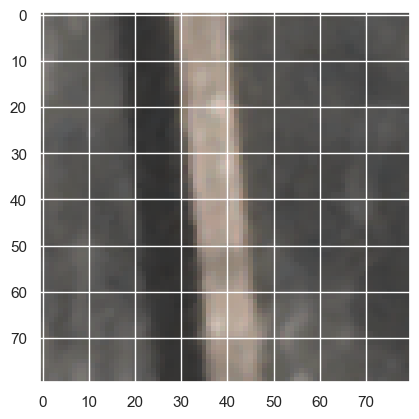

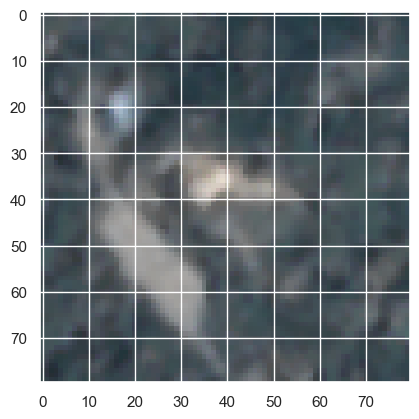

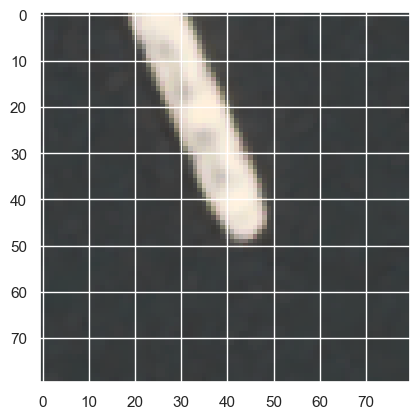

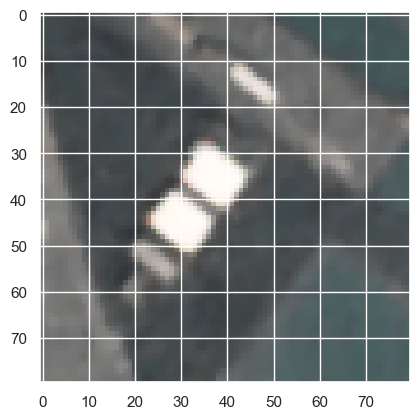

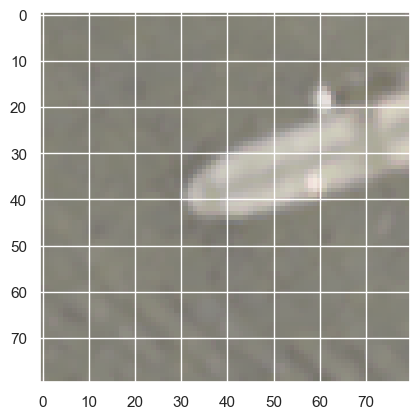

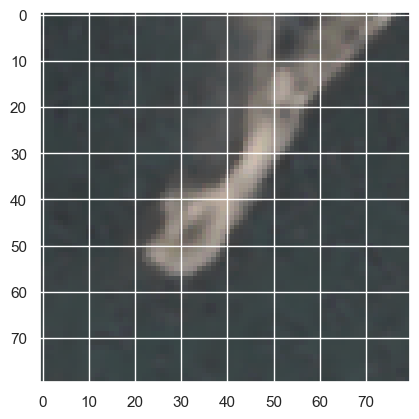

In [113]:
for i in errors_aug_class0:
    plt.imshow(i)
    plt.show()